##### Libraries

In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('scroll_down/main')
utils.load_extension('hide_input/main')
utils.load_extension('jupyter-js-widgets/extension')


<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
import seaborn as sns
import numpy as np

from pandas_profiling import ProfileReport

from sklearn.linear_model import Lasso

from category_encoders.one_hot import OneHotEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.cat_boost import CatBoostEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelBinarizer
from sklearn.metrics import mean_absolute_error, classification_report, roc_auc_score

from sklearn.tree import DecisionTreeRegressor, plot_tree
from catboost import CatBoostRegressor, CatBoostClassifier

import shap

from matplotlib import rcParams

rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

rcParams["figure.figsize"] = 16, 8

In [3]:
def plot_feature_importance(columnas,model_features,columns_ploted=10,model_name='Catboost'):
    '''
    This method is yet non-tested
    
    This function receives a set of columns feeded to a model, and the importance of each of feature.
    Returns a graphical visualization
    
    Call it fot catboost pipe example:
    plot_feature_importance(pipe_best_estimator[:-1].transform(X_tr).columns,pipe_best_estimator.named_steps['cb'].get_feature_importance(),20)
    
    Call it for lasso pipe example:
    plot_feature_importance(pipe_best_estimator[:-1].transform(X_tr).columns,np.array(pipe_best_estimator.named_steps['clf'].coef_.squeeze()),20)
    '''

    feature_importance = pd.Series(index = columnas, data = np.abs(model_features))
    n_selected_features = (feature_importance>0).sum()
    print('{0:d} features, reduction of {1:2.2f}%'.format(n_selected_features,(1-n_selected_features/len(feature_importance))*100))
    plt.figure()
    feature_importance.sort_values().tail(columns_ploted).plot(kind = 'bar', figsize = (18,6))
    plt.title('Feature Importance for {}'.format(model_name))
    plt.show()


In [4]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [7]:
file_path =  os.path.abspath(os.path.join('' ,"../..")) + '/Data/ntl_maharashtra.csv'

In [8]:
df = pd.read_csv(file_path)

In [12]:
df.shape

(48, 6)

In [13]:
df

,date,mean,min,max,median,kurtosis
0,2014-01-01T00:00:00,0.538501,-0.070533,25.652834,0.308175,163.898883
1,2014-02-01T00:00:00,0.651237,0.006167,26.212730,0.434233,150.660615
2,2014-03-01T00:00:00,0.687982,0.086043,23.514565,0.434720,148.271686
3,2014-04-01T00:00:00,0.755550,0.000000,21.927834,0.558781,144.888962
4,2014-05-01T00:00:00,0.607470,0.056884,24.507454,0.432732,178.548434
5,2014-06-01T00:00:00,0.543642,-0.094538,23.905602,0.310778,176.251723
6,2014-07-01T00:00:00,0.678495,-0.015084,28.500214,0.435094,198.686534
7,2014-08-01T00:00:00,0.433178,-0.158301,16.308443,0.309870,160.543904
8,2014-09-01T00:00:00,0.676796,0.094296,23.163847,0.435009,160.284691
9,2014-10-01T00:00:00,0.612113,-0.040054,29.640352,0.433648,167.736339


In [9]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [10]:
#profile.to_file("DHS_OSM_EDA_report.html")

## Modeling

In [9]:
cols_drop = [
    "DHSCLUST",
    "Wealth",
    "Wealth Index",
    "ADM1NAME",
    "LATNUM",
    "LONGNUM",
    "geometry",
    "DHSREGNA",
    "UN_Population_Density_2015",
]

scaler = MinMaxScaler()
df[["UN_Population_Density_2015"]] = scaler.fit_transform(
    df[["UN_Population_Density_2015"]]
)

X = df.drop(columns=cols_drop)
y = df[["Wealth Index"]]

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


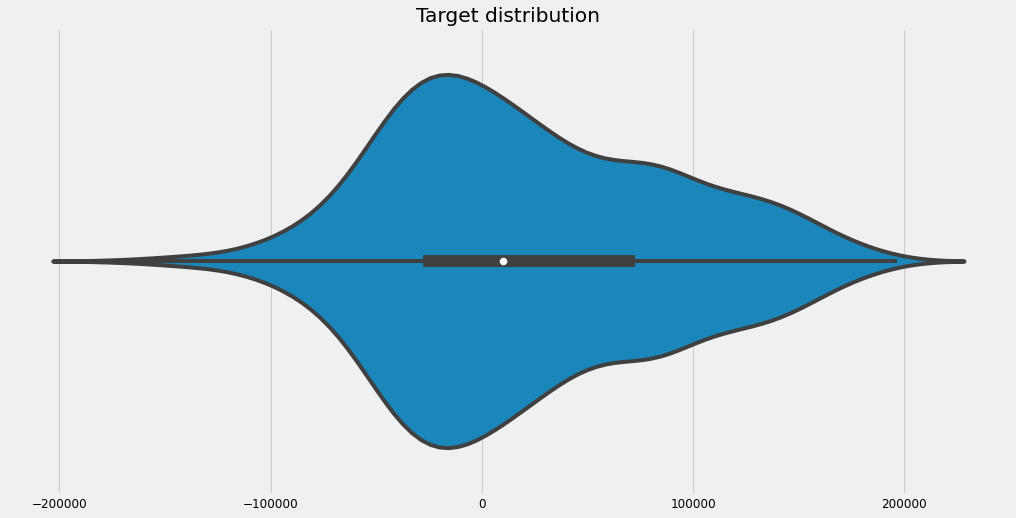

In [10]:
plt.figure()
plt.title('Target distribution')
sns.violinplot(y.values)
plt.show()

In [11]:
X.columns

Index(['Toilet Facility', 'Roof Material', 'Electricity', 'Cooking Fuel',
       'Drinking Water', 'URBAN_RURA', 'center_point', 'Population_Density',
       'center', 'amenity_bank', 'amenity_atm', 'amenity_bus_station',
       'amenity_cinema', 'amenity_fast_food', 'amenity_college',
       'amenity_toilets', 'amenity_clinic', 'amenity_hospital',
       'amenity_parking', 'amenity_university', 'amenity_school',
       'amenity_parking_space', 'amenity_bench', 'amenity_pharmacy',
       'amenity_restaurant', 'highway_bus_stop', 'highway_traffic_signals',
       'highway_crossing'],
      dtype='object')

In [12]:
X_tr,X_te,y_tr,y_te = train_test_split(X,y)

### Regression

#### Linear OHE

In [13]:
model = Lasso()
enc = OneHotEncoder(use_cat_names=True)

In [14]:
pipe = Pipeline([('enc',enc), ('model',model)])

In [15]:
pipe.fit(X_tr,y_tr)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Objective did not converge. You might want to increase the number of iterations. Duality gap: 23239160809.75978, tolerance: 453942929.2979291


Pipeline(steps=[('enc',
                 OneHotEncoder(cols=['Toilet Facility', 'Roof Material',
                                     'Electricity', 'Cooking Fuel',
                                     'Drinking Water', 'URBAN_RURA',
                                     'center_point', 'Population_Density',
                                     'center'],
                               use_cat_names=True)),
                ('model', Lasso())])

In [16]:
mean_absolute_error(pipe.predict(X_te),y_te)

23274.164164892794

1829 features, reduction of 11.43%


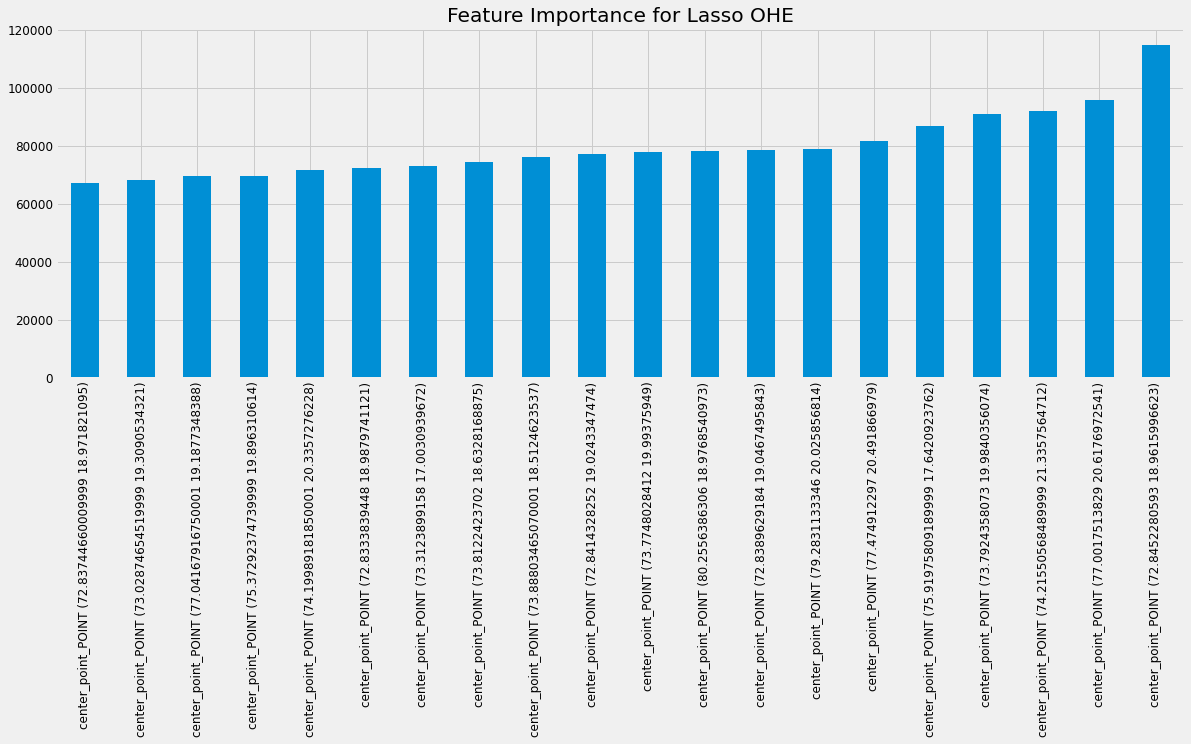

In [17]:
plot_feature_importance(
    pipe[:-1].transform(X_tr).columns,
    np.array(pipe.named_steps["model"].coef_.squeeze()),
    20,model_name='Lasso OHE'
)

#### Linear TE

In [18]:
model = Lasso()
enc = CatBoostEncoder()

pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 478127982066.3287, tolerance: 453942929.2979291


Pipeline(steps=[('enc',
                 CatBoostEncoder(cols=['Toilet Facility', 'Roof Material',
                                       'Electricity', 'Cooking Fuel',
                                       'Drinking Water', 'URBAN_RURA',
                                       'center_point', 'Population_Density',
                                       'center'])),
                ('model', Lasso())])

In [19]:
mean_absolute_error(pipe.predict(X_te),y_te)

23539.32690859608

26 features, reduction of 7.14%


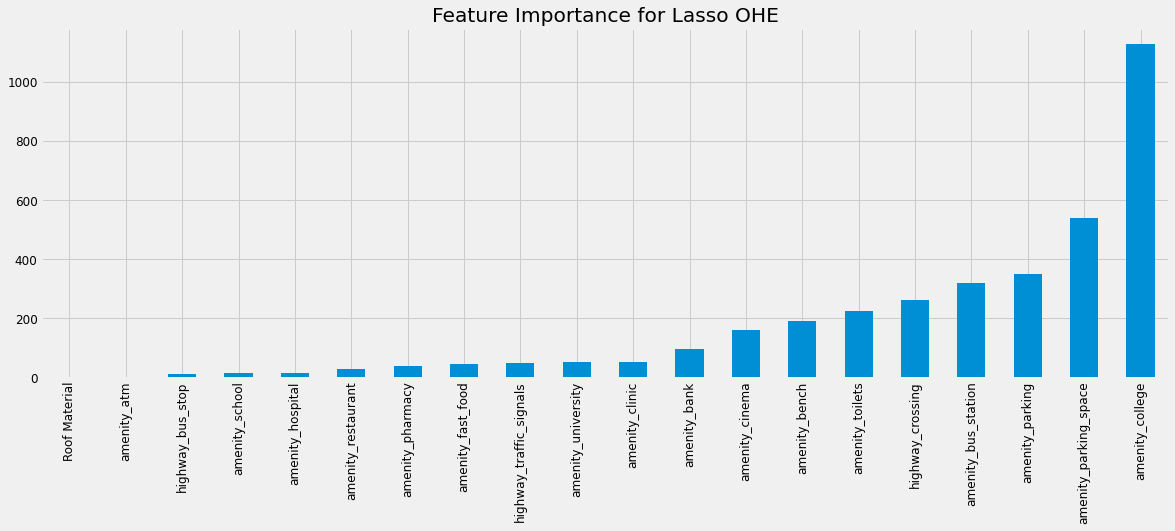

In [20]:
plot_feature_importance(
    pipe[:-1].transform(X_tr).columns,
    np.array(pipe.named_steps["model"].coef_.squeeze()),
    20,model_name='Lasso OHE'
)

#### Decision Tree TE

In [21]:
model = DecisionTreeRegressor(max_depth=5)
enc = CatBoostEncoder()

pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

Pipeline(steps=[('enc',
                 CatBoostEncoder(cols=['Toilet Facility', 'Roof Material',
                                       'Electricity', 'Cooking Fuel',
                                       'Drinking Water', 'URBAN_RURA',
                                       'center_point', 'Population_Density',
                                       'center'])),
                ('model', DecisionTreeRegressor(max_depth=5))])

In [22]:
mean_absolute_error(pipe.predict(X_te),y_te)

23534.860082124953

In [23]:
pipe.named_steps["model"]

DecisionTreeRegressor(max_depth=5)

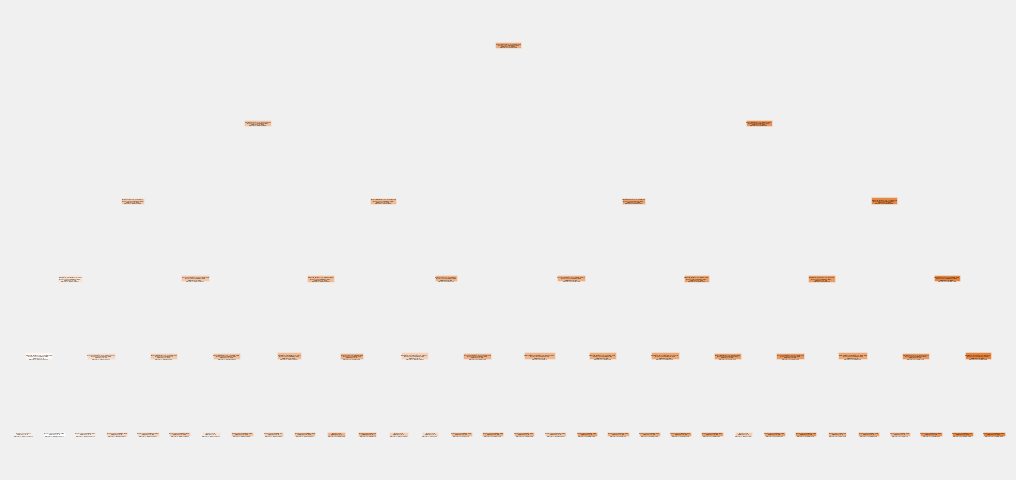

In [24]:
plt.figure()
plot_tree(
    pipe.named_steps["model"],
    max_depth=5,
    feature_names=X_tr.columns,
    filled=True,
)
plt.savefig('tree_te.svg',format='svg')
plt.show()

#### Decision Tree OHE

In [25]:
model = DecisionTreeRegressor(max_depth=8)
enc = OneHotEncoder()
pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Pipeline(steps=[('enc',
                 OneHotEncoder(cols=['Toilet Facility', 'Roof Material',
                                     'Electricity', 'Cooking Fuel',
                                     'Drinking Water', 'URBAN_RURA',
                                     'center_point', 'Population_Density',
                                     'center'])),
                ('model', DecisionTreeRegressor(max_depth=8))])

In [26]:
mean_absolute_error(pipe.predict(X_te),y_te)

24335.368216587347

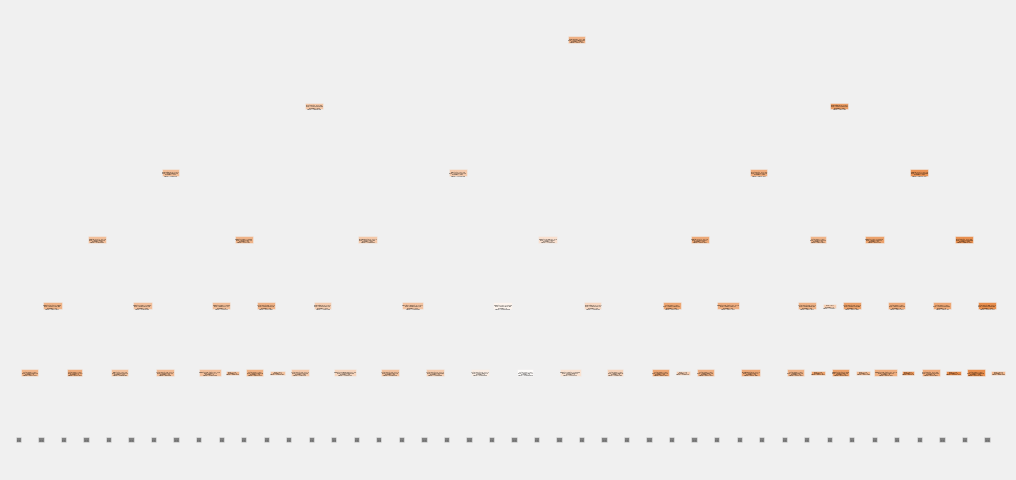

In [27]:
plt.figure()
plot_tree(
    pipe.named_steps["model"],
    max_depth=5,
    feature_names=pipe[:-1].transform(X_tr).columns,
    filled=True,
)
plt.savefig('tree_ohe.svg',format='svg')
plt.show()

#### Catboost TE

In [28]:
model = CatBoostRegressor(iterations=200,verbose=0)
enc = CatBoostEncoder()
pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

Pipeline(steps=[('enc',
                 CatBoostEncoder(cols=['Toilet Facility', 'Roof Material',
                                       'Electricity', 'Cooking Fuel',
                                       'Drinking Water', 'URBAN_RURA',
                                       'center_point', 'Population_Density',
                                       'center'])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7f8493c1d100>)])

In [29]:
mean_absolute_error(pipe.predict(X_te),y_te)

23209.727520154902

26 features, reduction of 7.14%


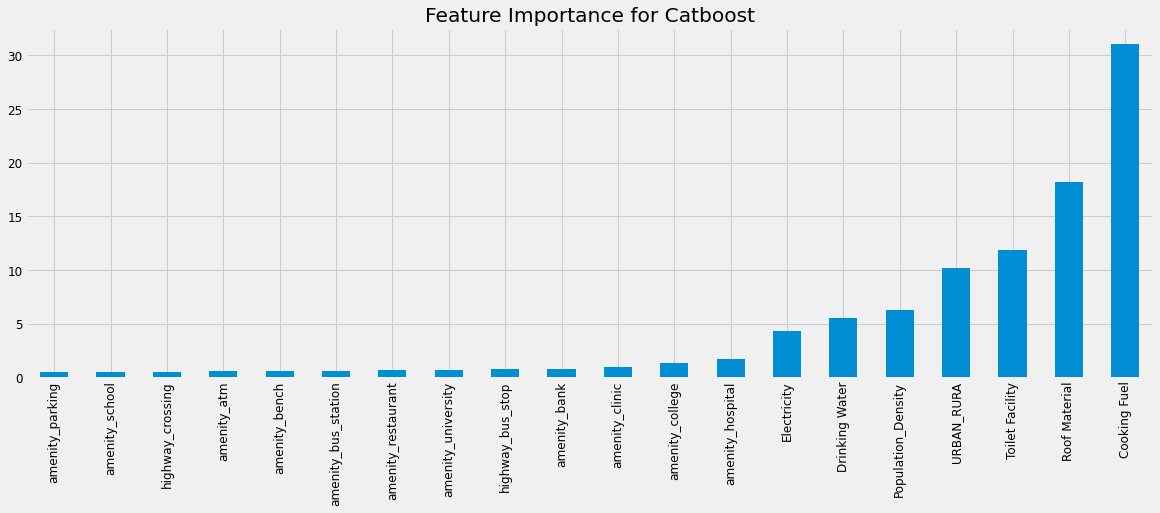

In [30]:
plot_feature_importance(
    pipe[:-1].transform(X_tr).columns,
    pipe.named_steps["model"].get_feature_importance(),
    20,
)

In [31]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(pipe.named_steps["model"])
shap_values = explainer.shap_values(pipe[:-1].transform(X_tr))

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

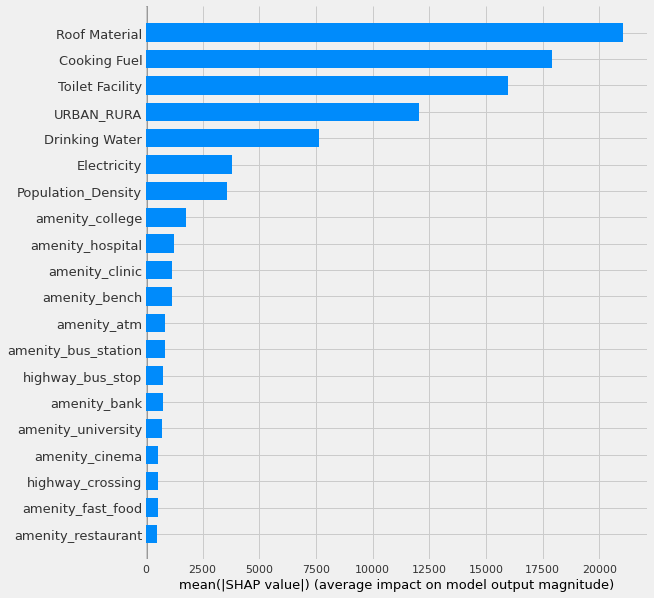

In [32]:
shap.summary_plot(shap_values, X_te, plot_type="bar")

## Classification

In [33]:
X = df.drop(columns=cols_drop)
y = df[["Wealth"]]

dic = {"richest": 1, "richer": 2, "middle": 3, "poorer": 4, "poorest": 5}
y = y.Wealth.map(dic)

X_tr,X_te,y_tr,y_te = train_test_split(X,y)

#### Catboost TE

In [34]:
model = CatBoostRegressor(iterations=200,verbose=0)
enc = CatBoostEncoder()
pipe = Pipeline([('enc',enc), ('model',model)])

pipe.fit(X_tr,y_tr)

Pipeline(steps=[('enc',
                 CatBoostEncoder(cols=['Toilet Facility', 'Roof Material',
                                       'Electricity', 'Cooking Fuel',
                                       'Drinking Water', 'URBAN_RURA',
                                       'center_point', 'Population_Density',
                                       'center'])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7f84a64b0580>)])

In [35]:
mean_absolute_error(pipe.predict(X_te),y_te)

0.646462165572244

In [36]:
preds = np.round(pipe.predict(X_te))
dic_rev = {v: k for k, v in dic.items()}
preds = pd.DataFrame(preds,columns=['predictions'])
y_test = preds.predictions.map(dic_rev)

In [37]:
print(classification_report(y_test,[dic_rev[k] for k in y_te]))

              precision    recall  f1-score   support

      middle       0.42      0.37      0.39        95
      poorer       0.62      0.45      0.52       107
     poorest       0.00      0.00      0.00         0
      richer       0.49      0.44      0.46        85
     richest       0.51      0.65      0.57        48

    accuracy                           0.45       335
   macro avg       0.41      0.38      0.39       335
weighted avg       0.52      0.45      0.48       335



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [38]:
multiclass_roc_auc_score(y_test,[dic_rev[k] for k in y_te],average=None)

array([0.58212719, 0.66070257, 0.64164706, 0.77065186])

26 features, reduction of 7.14%


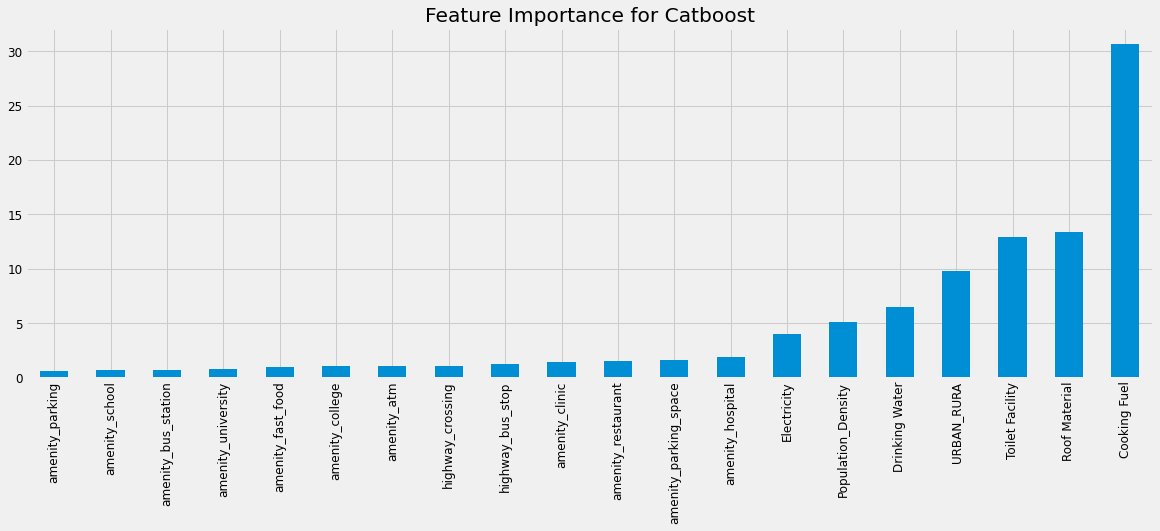

In [39]:
plot_feature_importance(
    pipe[:-1].transform(X_tr).columns,
    pipe.named_steps["model"].get_feature_importance(),
    20,
)

In [40]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(pipe.named_steps["model"])
shap_values = explainer.shap_values(pipe[:-1].transform(X_tr))

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

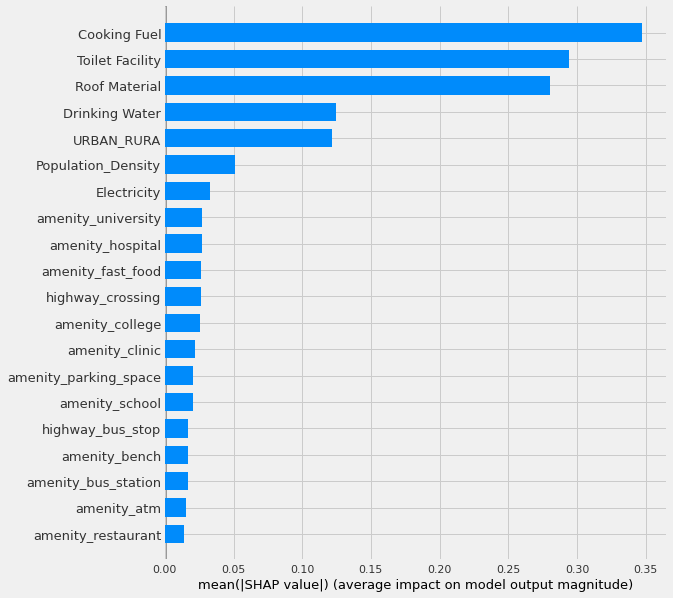

In [41]:
shap.summary_plot(shap_values, X_te, plot_type="bar")